In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline


In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image



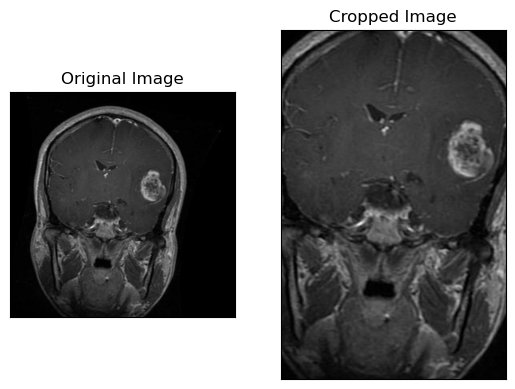

In [ ]:

ex_img = cv2.imread(r'C:\Users\ASUS\Desktop\Aug\yes\aug_Tr-gl_0092_0_7034.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_path = r'C:\Users\ASUS\Desktop\Aug/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 11664
X shape is: (11664, 240, 240, 3)
y shape is: (11664, 1)


In [ ]:
#Plot sample images:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


     

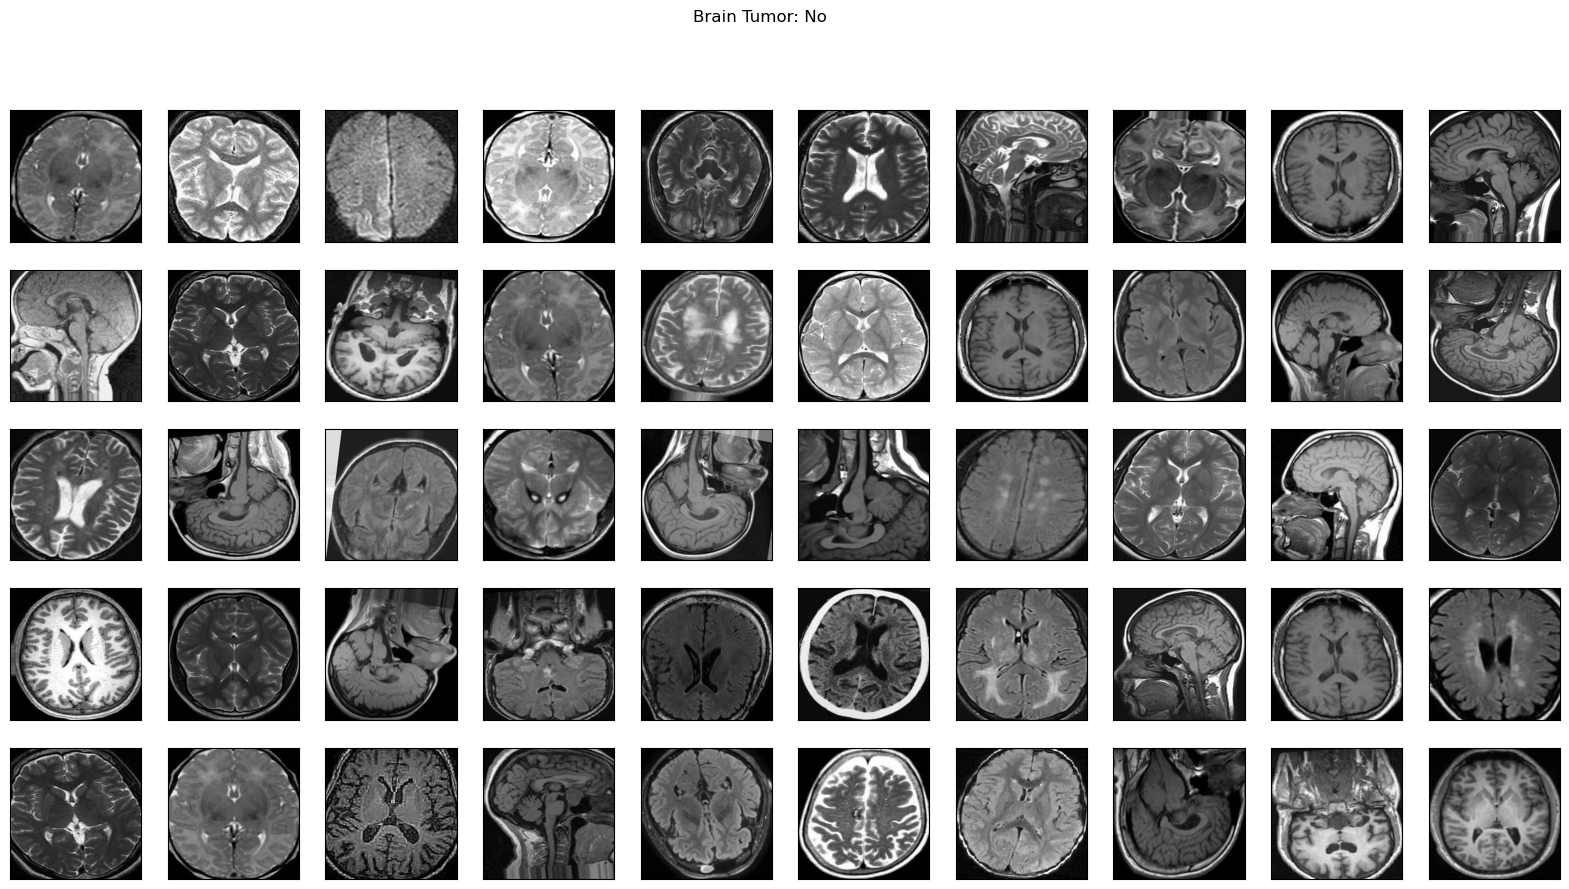

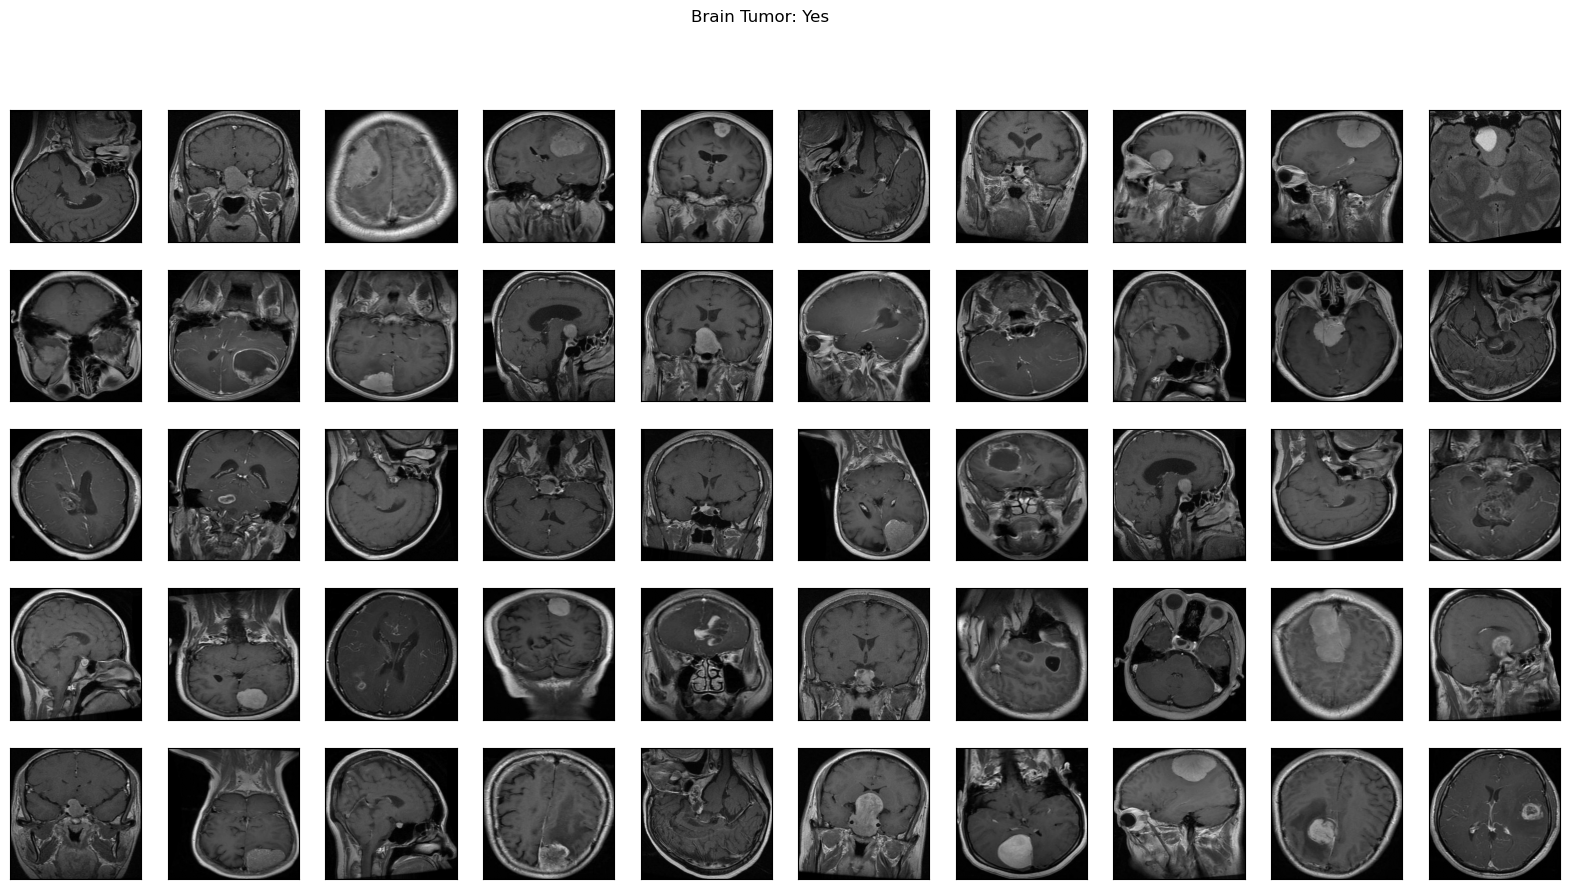

In [ ]:
plot_sample_images(X, y)

In [ ]:
#Splits data into training, development and test sets.
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 8164
number of development examples = 1750
number of test examples = 1750
X_train shape: (8164, 240, 240, 3)
Y_train shape: (8164, 1)
X_val (dev) shape: (1750, 240, 240, 3)
Y_val (dev) shape: (1750, 1)
X_test shape: (1750, 240, 240, 3)
Y_test shape: (1750, 1)


In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score


In [ ]:
#Build the model
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model


In [ ]:
#Define the image shape:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:

model = build_model(IMG_SHAPE)

In [ ]:

model.summary()


Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
#Compile the model:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


     

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Make sure output directory exists
os.makedirs("models", exist_ok=True)

# Corrected file path with .keras extension
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',   # Use 'val_accuracy', not 'val_acc' in Keras 3
    verbose=1,
    save_best_only=True,
    mode='max'
)

     

In [ ]:
#Train the model

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8035 - loss: 0.5365
Epoch 1: val_accuracy improved from -inf to 0.92000, saving model to models/cnn-parameters-improvement-01-0.92.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 166s 635ms/step - accuracy: 0.8038 - loss: 0.5357 - val_accuracy: 0.9200 - val_loss: 0.2528
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9136 - loss: 0.2142
Epoch 2: val_accuracy improved from 0.92000 to 0.95257, saving model to models/cnn-parameters-improvement-02-0.95.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 154s 602ms/step - accuracy: 0.9136 - loss: 0.2141 - val_accuracy: 0.9526 - val_loss: 0.1455
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9583 - loss: 0.1255
Epoch 3: val_accuracy did not improve from 0.95257
256/256 ━━━━━━━━━━━━━━━━━━━━ 200s 592ms/step - accuracy: 0.9582 - loss: 0.1255 - val_accuracy: 0.9389 - val_loss: 0.1732
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9553 - loss: 0.12

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9782 - loss: 0.0571
Epoch 1: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 173s 667ms/step - accuracy: 0.9782 - loss: 0.0572 - val_accuracy: 0.9634 - val_loss: 0.0941
Epoch 2/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9744 - loss: 0.0791
Epoch 2: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 152s 592ms/step - accuracy: 0.9744 - loss: 0.0791 - val_accuracy: 0.8709 - val_loss: 0.3509
Epoch 3/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9757 - loss: 0.0685
Epoch 3: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 160s 626ms/step - accuracy: 0.9757 - loss: 0.0685 - val_accuracy: 0.9697 - val_loss: 0.0893
Elapsed time: 0:11:57.7


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9854 - loss: 0.0397
Epoch 1: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 164s 637ms/step - accuracy: 0.9854 - loss: 0.0398 - val_accuracy: 0.9657 - val_loss: 0.0956
Epoch 2/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9880 - loss: 0.0386
Epoch 2: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 155s 604ms/step - accuracy: 0.9880 - loss: 0.0386 - val_accuracy: 0.9686 - val_loss: 0.0865
Epoch 3/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9820 - loss: 0.0605
Epoch 3: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 158s 618ms/step - accuracy: 0.9820 - loss: 0.0604 - val_accuracy: 0.9697 - val_loss: 0.1036
Elapsed time: 0:9:7.8


In [ ]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9815 - loss: 0.0443
Epoch 1: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 167s 648ms/step - accuracy: 0.9815 - loss: 0.0443 - val_accuracy: 0.9206 - val_loss: 0.2602
Epoch 2/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9877 - loss: 0.0387
Epoch 2: val_accuracy did not improve from 0.96971
256/256 ━━━━━━━━━━━━━━━━━━━━ 161s 627ms/step - accuracy: 0.9876 - loss: 0.0388 - val_accuracy: 0.8297 - val_loss: 0.5348
Epoch 3/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9796 - loss: 0.0568
Epoch 3: val_accuracy improved from 0.96971 to 0.97086, saving model to models/cnn-parameters-improvement-03-0.97.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 156s 609ms/step - accuracy: 0.9796 - loss: 0.0568 - val_accuracy: 0.9709 - val_loss: 0.0770
Elapsed time: 0:9:26.8


In [ ]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")



Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9874 - loss: 0.0395
Epoch 1: val_accuracy did not improve from 0.97086
256/256 ━━━━━━━━━━━━━━━━━━━━ 163s 633ms/step - accuracy: 0.9874 - loss: 0.0395 - val_accuracy: 0.9663 - val_loss: 0.1263
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9858 - loss: 0.0347
Epoch 2: val_accuracy improved from 0.97086 to 0.97200, saving model to models/cnn-parameters-improvement-02-0.97.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 154s 600ms/step - accuracy: 0.9858 - loss: 0.0347 - val_accuracy: 0.9720 - val_loss: 0.0903
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9865 - loss: 0.0407
Epoch 3: val_accuracy did not improve from 0.97200
256/256 ━━━━━━━━━━━━━━━━━━━━ 153s 598ms/step - accuracy: 0.9865 - loss: 0.0407 - val_accuracy: 0.9709 - val_loss: 0.0909
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9859 - loss: 0.0395
Epoch 4: val_accuracy improved from 0.97200 to 0.97714, saving mode

In [ ]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")



Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9886 - loss: 0.0318
Epoch 1: val_accuracy did not improve from 0.97714
256/256 ━━━━━━━━━━━━━━━━━━━━ 206s 799ms/step - accuracy: 0.9886 - loss: 0.0318 - val_accuracy: 0.9709 - val_loss: 0.0961
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9846 - loss: 0.0429
Epoch 2: val_accuracy did not improve from 0.97714
256/256 ━━━━━━━━━━━━━━━━━━━━ 181s 704ms/step - accuracy: 0.9846 - loss: 0.0429 - val_accuracy: 0.9754 - val_loss: 0.0890
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9839 - loss: 0.0427
Epoch 3: val_accuracy did not improve from 0.97714
256/256 ━━━━━━━━━━━━━━━━━━━━ 176s 689ms/step - accuracy: 0.9839 - loss: 0.0427 - val_accuracy: 0.6423 - val_loss: 1.7372
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9918 - loss: 0.0247
Epoch 4: val_accuracy did not improve from 0.97714
256/256 ━━━━━━━━━━━━━━━━━━━━ 176s 688ms/step - accuracy: 0.9918 - loss: 0.0247 - 

In [ ]:

history = model.history.history


In [ ]:

for key in history.keys():
    print(key)



accuracy
loss
val_accuracy
val_loss


In [ ]:

def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()



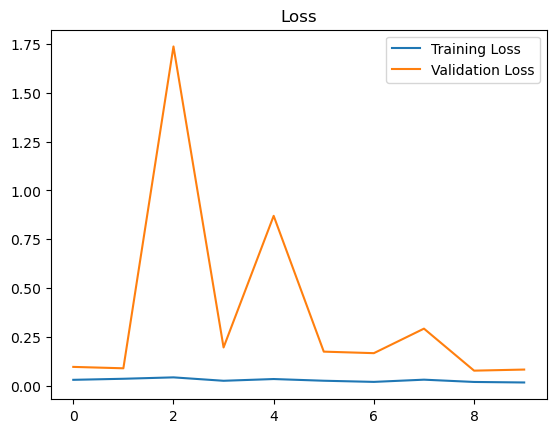

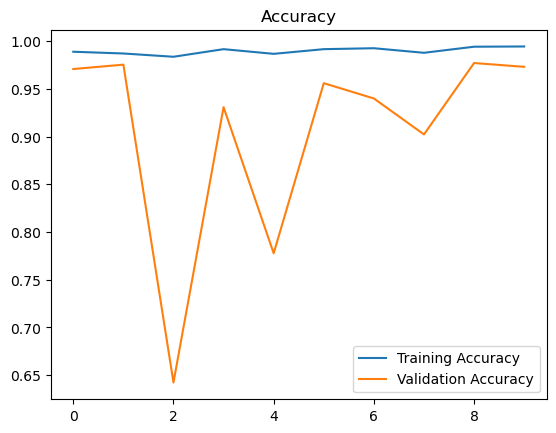

In [ ]:

plot_metrics(history) 


In [ ]:
import os
import re

def find_best_model(directory):
    best_model = None
    best_accuracy = -1

    # Regular expression to extract accuracy from filenames
    pattern = r"cnn-parameters-improvement-\d{2}-(\d+\.\d+)\.keras"

    for filename in os.listdir(directory):
        match = re.search(pattern, filename)
        if match:
            accuracy = float(match.group(1))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = filename

    if best_model:
        print(f"Best model: {best_model} with val_accuracy: {best_accuracy}")
        return os.path.join(directory, best_model)
    else:
        print("No valid model files found.")
        return None


In [ ]:
best_model_path = find_best_model("models")  # or your model directory

if best_model_path:
    from tensorflow.keras.models import load_model
    best_model = load_model(best_model_path)


Best model: cnn-parameters-improvement-04-0.98.keras with val_accuracy: 0.98


In [ ]:
import os

print(os.listdir("models"))


['cnn-parameters-improvement-01-0.92.keras', 'cnn-parameters-improvement-02-0.95.keras', 'cnn-parameters-improvement-02-0.97.keras', 'cnn-parameters-improvement-03-0.97.keras', 'cnn-parameters-improvement-04-0.98.keras', 'cnn-parameters-improvement-07-0.97.keras', 'cnn-parameters-improvement-10-0.97.keras']


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('models/cnn-parameters-improvement-04-0.98.keras')


In [ ]:

best_model.metrics_names

['loss', 'compile_metrics']

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9809 - loss: 0.0649


In [ ]:

print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")



Test Loss = 0.06099390611052513
Test Accuracy = 0.9782857298851013


In [ ]:
#F1 score for the best model on the testing data:

y_test_prob = best_model.predict(X_test)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step


In [ ]:

f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")


     

F1 score: 0.9800420168067226


In [ ]:

y_val_prob = best_model.predict(X_val)



55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step


In [ ]:

f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")



F1 score: 0.9775784753363229


In [ ]:
#Results Interpretation

def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


     

In [ ]:

# the whole data
data_percentage(y)



Number of examples: 11664
Percentage of positive examples: 52.85493827160494%, number of pos examples: 6165
Percentage of negative examples: 47.14506172839506%, number of neg examples: 5499


In [ ]:

print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)



Training Data:
Number of examples: 8164
Percentage of positive examples: 52.96423321901029%, number of pos examples: 4324
Percentage of negative examples: 47.03576678098971%, number of neg examples: 3840
Validation Data:
Number of examples: 1750
Percentage of positive examples: 50.91428571428571%, number of pos examples: 891
Percentage of negative examples: 49.08571428571429%, number of neg examples: 859
Testing Data:
Number of examples: 1750
Percentage of positive examples: 54.285714285714285%, number of pos examples: 950
Percentage of negative examples: 45.714285714285715%, number of neg examples: 800


In [ ]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('model.h5')  # replace with your model's filename

# Image size used during training
# Automatically get expected input size from model
IMG_SIZE = model.input_shape[1]

def preprocess_image(image_path):
    """Preprocess the input image for prediction."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def predict():
    """Handle image upload and prediction."""
    file_path = filedialog.askopenfilename()
    if not file_path:
        return

    # Display the selected image
    img = Image.open(file_path)
    img.thumbnail((200, 200))
    img = ImageTk.PhotoImage(img)
    image_label.config(image=img)
    image_label.image = img

    # Preprocess and predict
    preprocessed = preprocess_image(file_path)
    prediction = model.predict(preprocessed)[0][0]

    # Interpret prediction
    label = "Tumor Detected" if prediction > 0.5 else "No Tumor"
    result_label.config(text=f"Prediction: {label} ({prediction:.2f})")

# Create the GUI window
root = tk.Tk()
root.title("MRI Tumor Detection")
root.geometry("400x400")

# Upload button
upload_btn = tk.Button(root, text="Upload MRI Image", command=predict)
upload_btn.pack(pady=20)

# Image display
image_label = tk.Label(root)
image_label.pack()

# Prediction result
result_label = tk.Label(root, text="", font=("Arial", 16))
result_label.pack(pady=20)

# Start the GUI loop
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
